# Introduction

In this notebook I will be considering the [discrete Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment from OpenAI gym. Specifically, I will look to train three agents using three different RL algorithms to solve the problem presented by said environment. The algorithms I will consider are all variants of Deep Q-Learning (DQN): standard DQN, Double DQN, and C51 DQN. The first and last methods we have discussed in class, and C51 is a variant of DQN that learns a distribution over the Q-value.

We will be using TensorFlow Agents as a framework for training, and we will also use the following tutorials as a partial guide:
- [Cartpole DQN](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial)
- [Cartpole C51 DQN](https://www.tensorflow.org/agents/tutorials/9_c51_tutorial)

# Setup

We begin by setting up some general things including a display for showing the environment, and hyperparameters used in our methods.

In [1]:
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

In [2]:
display = pyvirtualdisplay.Display(visible=0, size=(1400,900)).start()

In [59]:
#General
env_name = 'LunarLander-v2'

num_iterations = 10000 #Number of iterations to train

initial_collect_steps = 100 #Initial fill size for buffer
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000 #Max buffer size

batch_size = 64
learning_rate = 1e-3
log_interval = 100 #For logging info

num_eval_episodes = 10 
eval_interval = 1000 #For evaluating agent

#C51 specific
gamma = 0.99
num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 2

# Environment

As stated before, we will be using the discrete Lunar Lander environment. The goal of this environment is to land in-between the flags, and the agent has four actions to select from. These actions are fire left engine, fire right engine, fire main engine, and do nothing.

In [4]:
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment

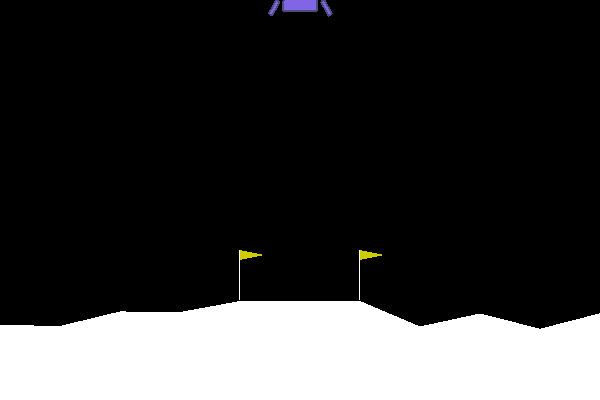

In [5]:
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

We can see an example rendered image from the environment above. Becuase it is from the beginning of the episode the lander is still high in the air. Now we will set up training and testing environments of the same type for our agents to use.

In [30]:
env.close()
train_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

test_py_env = suite_gym.load(env_name)
test_env = tf_py_environment.TFPyEnvironment(test_py_env)

# Agents

Next, we need to build our agents and the neural networks they use.

In [7]:
from tf_agents.agents.dqn import dqn_agent as dqn
from tf_agents.agents.ppo import ppo_agent as ppo
from tf_agents.agents.categorical_dqn import categorical_dqn_agent as cat_dqn

from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, categorical_q_network, actor_distribution_network, value_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

Each of the Q-networks will be the same size with two fully connected layers of the sizes seen below.

In [60]:
fc_params = (100, 50)

time_spec = train_env.time_step_spec()
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()

We first define our standard DQN network and the associated agent.

In [61]:
#Q-network
dqn_net = q_network.QNetwork(observation_spec, action_spec,
                                fc_layer_params=fc_params)

dqn_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

dqn_counter = tf.Variable(0)

dqn_agent = dqn.DqnAgent(time_spec, action_spec, q_network=dqn_net,
                    optimizer=dqn_optimizer,
                    td_errors_loss_fn=common.element_wise_squared_loss,
                    train_step_counter=dqn_counter)

dqn_agent.initialize()

Then we define our double DQN network and its agent.

In [62]:
#Double Q-network
ddqn_net = q_network.QNetwork(observation_spec, action_spec,
                                fc_layer_params=fc_params)

ddqn_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

ddqn_counter = tf.Variable(0)

ddqn_agent = dqn.DdqnAgent(time_spec, action_spec, q_network=ddqn_net,
                    optimizer=ddqn_optimizer,
                    td_errors_loss_fn=common.element_wise_squared_loss,
                    train_step_counter=ddqn_counter)

ddqn_agent.initialize()

Lastly, we define the C51 DQN network and its agent.

In [63]:
#C51 Q-network
c51_net = categorical_q_network.CategoricalQNetwork(observation_spec,
                                        action_spec,
                                        num_atoms=num_atoms,
                                        fc_layer_params=fc_params)

c51_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

c51_counter = tf.Variable(0)

c51_agent = cat_dqn.CategoricalDqnAgent(time_spec, action_spec,
                    categorical_q_network=c51_net,
                    optimizer=c51_optimizer,
                    min_q_value=min_q_value,
                    max_q_value=max_q_value,
                    n_step_update=n_step_update,
                    td_errors_loss_fn=common.element_wise_squared_loss,
                    gamma=gamma,
                    train_step_counter=c51_counter)

c51_agent.initialize()

## Metrics and Evaluation

Below we define a function that we can use to compute the average return over a given number of episodes. This will allow us to evaluate our agents as we learn.

In [35]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

## Training

The final step is to define how our agents will train, and thus how the network parameters will get updated. The collect step and collect data functions allow us to execute actions according to a policy and add them to a replay buffer. The build buffer function will build this replay buffer and seed it with data obtained by acting according to a random policy. Lastly, the train agent function trains an agent by sampling from the replay buffer.

In [36]:
def collect_step(env, policy, buffer):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, 
                                      next_time_step)

    buffer.add_batch(traj)
    
def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


def build_buffer(agent, env, **kw):
    buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                                        agent.collect_data_spec,
                                        batch_size=kw['buffer_batch_size'],
                                        max_length=kw['max_length'])
    
    random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                    env.action_spec())
    
    collect_data(env, random_policy, buffer, kw['collect_steps'])
    
    dataset = buffer.as_dataset(num_parallel_calls=3,
                                   sample_batch_size=kw['batch_size'],
                                   num_steps=kw['step_update']).prefetch(3)
    
    return buffer, iter(dataset)
    

def train_agent(agent, train_env, test_env, replay_buffer, iterator, **kw):
    agent.train = common.function(agent.train)
    
    agent.train_step_counter.assign(0)
    
    returns = [compute_avg_return(test_env, agent.policy, 
                                  kw['num_eval_episodes'])]
    
    for _ in range(kw['num_iterations']):
        collect_data(train_env, agent.collect_policy, replay_buffer, 
                     kw['collect_steps'])

        experience, _ = next(iterator)
        train_loss = agent.train(experience).loss

        step = agent.train_step_counter.numpy()

        if step % kw['log_interval'] == 0:
            print(f'step = {step}: loss = {train_loss}')

        if step % kw['eval_interval'] == 0:
            avg_return = compute_avg_return(test_env, agent.policy, 
                                            kw['num_eval_episodes'])
                        
            print(f'step = {step}: Average Return = {avg_return}')
            returns.append(avg_return)
                        
    return returns

Now we simply call the required functions to train our agents.

In [64]:
history = []

In [65]:
buffer, iterator = build_buffer(dqn_agent, train_env, step_update=2, 
                                batch_size=batch_size,
                                buffer_batch_size=train_env.batch_size,
                                max_length=replay_buffer_max_length,
                                collect_steps=initial_collect_steps)

hist = train_agent(dqn_agent, train_env, test_env, buffer, iterator, 
            collect_steps=collect_steps_per_iteration, 
            num_iterations=num_iterations,
            log_interval=log_interval, eval_interval=eval_interval,
            num_eval_episodes=num_eval_episodes)

history.append(hist)

step = 100: loss = 3.5311994552612305
step = 200: loss = 105.49629974365234
step = 300: loss = 9.693025588989258
step = 400: loss = 12.369256973266602
step = 500: loss = 371.3669738769531
step = 600: loss = 122.06590270996094
step = 700: loss = 282.3180847167969
step = 800: loss = 13.206583976745605
step = 900: loss = 10.356185913085938
step = 1000: loss = 112.16261291503906
step = 1000: Average Return = -383.29412841796875
step = 1100: loss = 572.5215454101562
step = 1200: loss = 19.4019775390625
step = 1300: loss = 154.16217041015625
step = 1400: loss = 33.270755767822266
step = 1500: loss = 26.97216796875
step = 1600: loss = 17.937578201293945
step = 1700: loss = 93.21180725097656
step = 1800: loss = 15.606100082397461
step = 1900: loss = 420.90875244140625
step = 2000: loss = 112.41667175292969
step = 2000: Average Return = -113.26336669921875
step = 2100: loss = 133.6841583251953
step = 2200: loss = 12.94791030883789
step = 2300: loss = 407.4003601074219
step = 2400: loss = 8.3294

In [66]:
buffer, iterator = build_buffer(ddqn_agent, train_env, step_update=2, 
                                batch_size=batch_size,
                                buffer_batch_size=train_env.batch_size,
                                max_length=replay_buffer_max_length,
                                collect_steps=initial_collect_steps)

hist = train_agent(ddqn_agent, train_env, test_env, buffer, iterator, 
            collect_steps=collect_steps_per_iteration, 
            num_iterations=num_iterations,
            log_interval=log_interval, eval_interval=eval_interval,
            num_eval_episodes=num_eval_episodes)

history.append(hist)

step = 100: loss = 152.9994659423828
step = 200: loss = 6.406069755554199
step = 300: loss = 40.092811584472656
step = 400: loss = 42.534549713134766
step = 500: loss = 137.08453369140625
step = 600: loss = 83.46482849121094
step = 700: loss = 50.60900115966797
step = 800: loss = 50.20509338378906
step = 900: loss = 52.86635971069336
step = 1000: loss = 62.08844757080078
step = 1000: Average Return = -627.660888671875
step = 1100: loss = 45.644935607910156
step = 1200: loss = 37.19023513793945
step = 1300: loss = 27.855121612548828
step = 1400: loss = 34.38987731933594
step = 1500: loss = 233.51510620117188
step = 1600: loss = 17.694141387939453
step = 1700: loss = 45.013954162597656
step = 1800: loss = 51.13549041748047
step = 1900: loss = 12.311495780944824
step = 2000: loss = 47.6790657043457
step = 2000: Average Return = -256.8296203613281
step = 2100: loss = 21.51862335205078
step = 2200: loss = 79.03032684326172
step = 2300: loss = 9.989171981811523
step = 2400: loss = 136.299942

In [67]:
buffer, iterator = build_buffer(c51_agent, train_env, step_update=n_step_update+1, 
                                batch_size=batch_size,
                                buffer_batch_size=train_env.batch_size,
                                max_length=replay_buffer_max_length,
                                collect_steps=initial_collect_steps)

hist = train_agent(c51_agent, train_env, test_env, buffer, iterator, 
            collect_steps=collect_steps_per_iteration, 
            num_iterations=num_iterations,
            log_interval=log_interval, eval_interval=eval_interval,
            num_eval_episodes=num_eval_episodes)

history.append(hist)

step = 100: loss = 3.3174028396606445
step = 200: loss = 3.364882707595825
step = 300: loss = 3.440462350845337
step = 400: loss = 2.9723730087280273
step = 500: loss = 2.7596447467803955
step = 600: loss = 2.701406240463257
step = 700: loss = 3.0327086448669434
step = 800: loss = 2.719785213470459
step = 900: loss = 3.095963716506958
step = 1000: loss = 3.0325927734375
step = 1000: Average Return = 44.74672317504883
step = 1100: loss = 2.8896517753601074
step = 1200: loss = 3.1868786811828613
step = 1300: loss = 3.2055840492248535
step = 1400: loss = 3.079336643218994
step = 1500: loss = 3.069816827774048
step = 1600: loss = 2.8962531089782715
step = 1700: loss = 3.0565521717071533
step = 1800: loss = 3.2108490467071533
step = 1900: loss = 3.1223835945129395
step = 2000: loss = 3.059845447540283
step = 2000: Average Return = -39.551570892333984
step = 2100: loss = 3.314816474914551
step = 2200: loss = 3.2200124263763428
step = 2300: loss = 3.1945881843566895
step = 2400: loss = 3.2399

Great, we trained for 10000 iterations for each agent, and things seem to have gone well. We can plot the history of average reward obtained during training to see how our agents have learned.

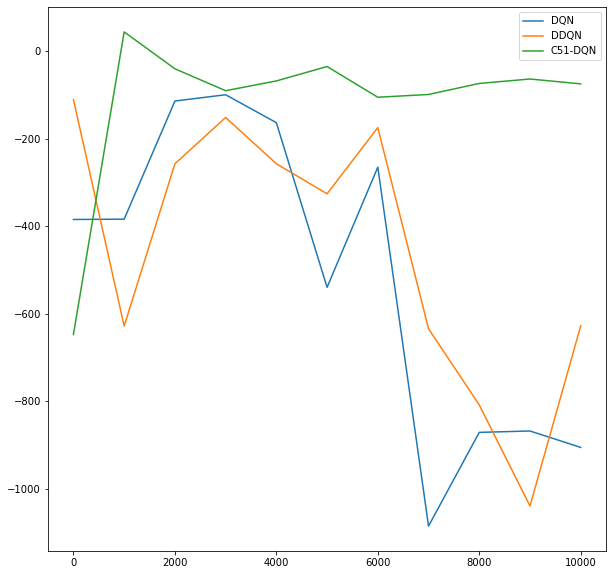

In [73]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

x = range(0, num_iterations+1, eval_interval)
for hist in history:
    ax.plot(x, hist)
    
ax.legend(['DQN', 'DDQN', 'C51-DQN']);

It's looking like DQN and DDQN haven't done so well, but C51 has done pretty good.

The most useful visualization will be from watching the agents act out their learned policies inside of the environment. We will define a function to do this below.

In [69]:
'''Source: https://www.tensorflow.org/agents/tutorials/9_c51_tutorial'''
import base64

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

def policyViz(filename, agent, env, py_env, num_episodes=3):
    with imageio.get_writer(filename, fps=60) as video:
        for _ in range(num_episodes):
            time_step = env.reset()
            video.append_data(py_env.render())
            while not time_step.is_last():
                action_step = agent.policy.action(time_step)
                time_step = env.step(action_step.action)
                video.append_data(py_env.render())
    
    return embed_mp4(filename)

In [70]:
policyViz('dqn_agent.mp4', dqn_agent, test_env, test_py_env)

Clearly the learned policy is doing pretty bad.

In [71]:
policyViz('ddqn_agent.mp4', ddqn_agent, test_env, test_py_env)

Same thing here.

In [72]:
policyViz('c51_agent.mp4', c51_agent, test_env, test_py_env)

Wow! The difference in learned policy here is striking. It seems that the C51 agents has done a great job. We can see that in multiple instances the lander succeeds in landing in-between the flags. I am not that familiar with C51, but it is clearly superior in this scenario.